In [1]:
import xmltodict, json
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

## Convert dataset

In [4]:
o = xmltodict.parse(open("all.xml",'r',encoding='utf-8').read())
a  = json.dumps(o, indent=2,ensure_ascii=False) # '{"e": {"a": ["text", "text"]}}'

In [6]:
with open("all.json", 'w', encoding='utf-8') as fd:
    fd.write(a)

## Filter dataset

In [2]:
with open("../data/all.json", 'r', encoding='utf-8') as fd:
    data = json.loads(fd.read())

In [7]:
BASE_MODEL = '/home/dzigen/Desktop/ITMO/sem1/DLtech/dl_tech_learn/lab3/pretrained_models/fffrrt_ruGPT-3.5-13B-GPTQ4'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

In [9]:
text_lens, title_lens = [], []
selected_item_ids = []
text_char_lens = []

no_title_ids = []

for i, item in tqdm(enumerate(data['items']['item'])):
    encoded_t = tokenizer.encode(item['text'])
    if len(encoded_t) >= 500:
        continue

    if item['name'] is not None:
        selected_item_ids.append(i)
        title_lens.append(len(tokenizer.encode(item['name'])))
        text_lens.append(len(encoded_t))
        text_char_lens.append(len(item['text']))
    else:
        no_title_ids.append(i)

print(len(no_title_ids), len(text_lens))

16694it [00:12, 1342.07it/s]

505 14846


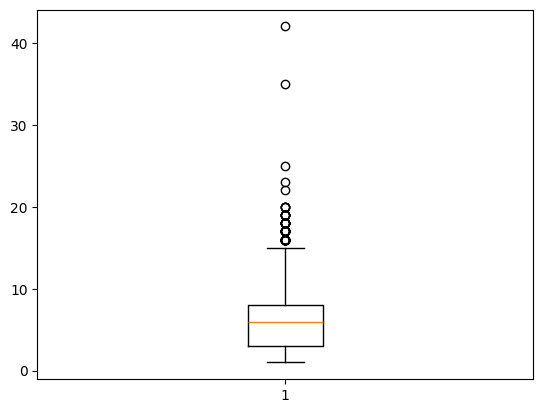

In [25]:
plt.boxplot(title_lens)
plt.show()

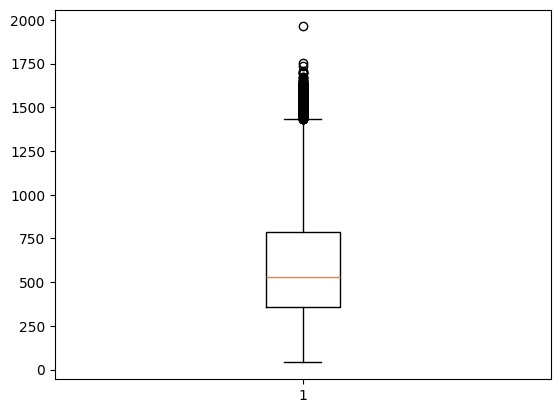

In [10]:
plt.boxplot(text_char_lens)
plt.show()

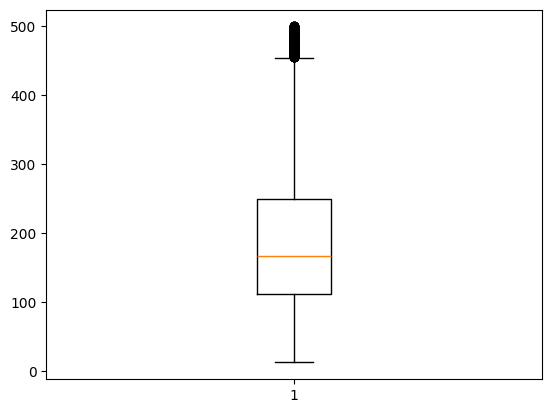

In [26]:
plt.boxplot(text_lens)
plt.show()

In [27]:
df = pd.DataFrame([[data['items']['item'][i]['text'],data['items']['item'][i]['name']] for i in selected_item_ids], columns=['text','title'])

In [28]:
df.to_csv("rupoems_dataset.csv", index=False, sep=';')

# Train/test split

In [29]:
BASE_DATASET = "rupoems_dataset.csv"

In [30]:
df = pd.read_csv(BASE_DATASET, sep=';')

In [31]:
X_train, X_test = train_test_split(df, test_size=0.15)

In [32]:
X_train.to_csv("train_part.csv", sep=';', index=False)

In [33]:
X_test.to_csv("test_part.csv", sep=';', index=False)